In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

colors = ["cornflowerblue", "indianred", "darkseagreen", "plum", "dimgray"]


# --- Limpieza de datos según lo indicado ---
df = pd.read_csv('Data/titanic.csv')
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
df = pd.get_dummies(df)
del df['Sex_female']
df['Age'] = df['Age'].fillna(df.Age.mean())

# Variables predictoras y variable objetivo
X = df.drop('Survived', axis=1)
y = df['Survived']

# --- División en conjunto de entrenamiento y test (80%-20%) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [11]:
# Crea un gradient boosting
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, max_depth=4, random_state=42).fit(X_train, y_train)

predicciones = model.predict_proba(X_test)[:,1]

print('AUC:', roc_auc_score(y_test, predicciones))

AUC: 0.792094861660079


In [7]:
## Cross validation 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
     ('gbt', GradientBoostingClassifier(n_estimators=300))
     ])

params = {
     'gbt__max_depth': [2, 3, 4, 5],
     'gbt__learning_rate': [0.1, 0.5, 0.01]
}

grid_gbt = GridSearchCV(estimator=pipeline, param_grid=params, cv=5, n_jobs=-1, scoring="roc_auc").fit(X_train, y_train)

In [9]:
# Mejor estimador 
grid_gbt.best_params_

{'gbt__learning_rate': 0.1, 'gbt__max_depth': 2}

In [12]:
# AUC
best_model = grid_gbt.best_estimator_.named_steps['gbt']
predicciones = best_model.predict_proba(X_test)[:,1]
print('AUC:', roc_auc_score(y_test, predicciones))

AUC: 0.7951910408432148


In [5]:
## Calibracion

/var/folders/tr/mb4tgd2j63j6tf50s0kl_p680000gn/T/ipykernel_46684/3923727249.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importancia", y="Variable", data=model_interpretability, palette=custom_palette)


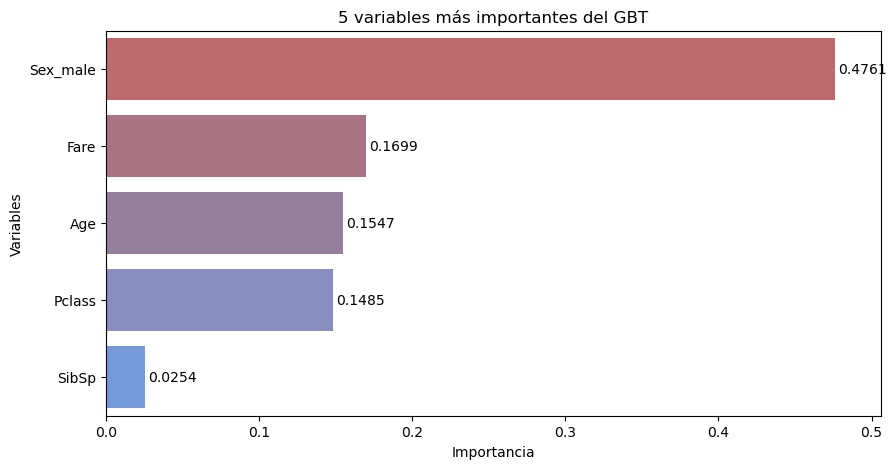

In [15]:
# Entendiendo el modelo 
def interpretability(X, model, n_var):
    model_interpretability = pd.DataFrame({
          'Variable': X.keys(),
          'Importancia': model.feature_importances_
    })
    model_interpretability = model_interpretability.sort_values(by='Importancia', ascending=False).head(n_var)

    cmap = LinearSegmentedColormap.from_list("custom_coolwarm", [colors[1], colors[0]])
    custom_palette = sns.color_palette([cmap(i) for i in np.linspace(0, 1, len(model_interpretability))])

    plt.figure(figsize=(10, 5))
    sns.barplot(x="Importancia", y="Variable", data=model_interpretability, palette=custom_palette)
    for index, value in enumerate(model_interpretability["Importancia"]):
        plt.text(value + 0.002, index, f"{value:.4f}", va="center", fontsize=10)
    plt.xlabel('Importancia')
    plt.xlim(0, max(model_interpretability["Importancia"]) + 0.03)
    plt.ylabel('Variables')
    plt.title(f'{n_var} variables más importantes del GBT')
    plt.show()

interpretability(X, best_model, 5)

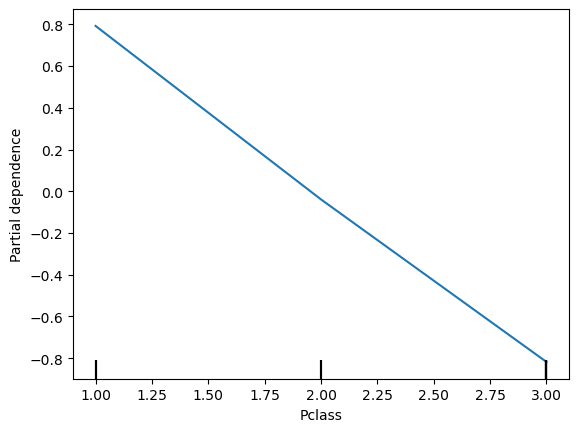

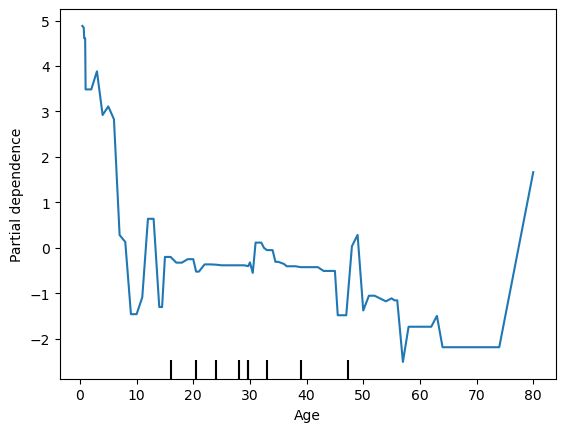

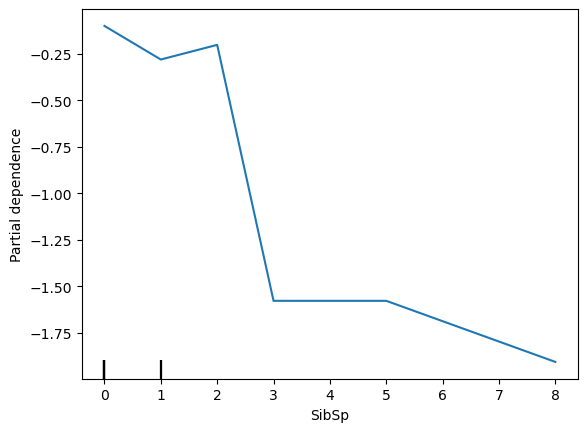

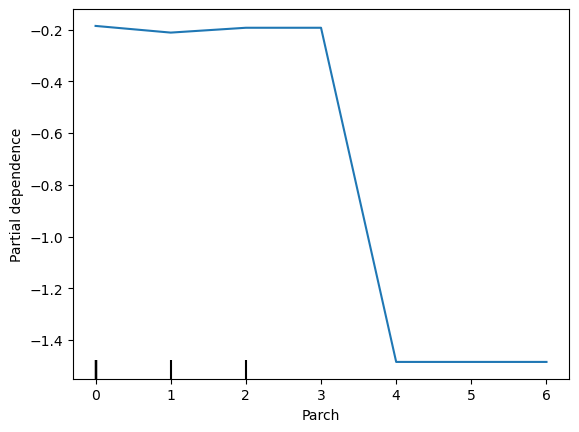

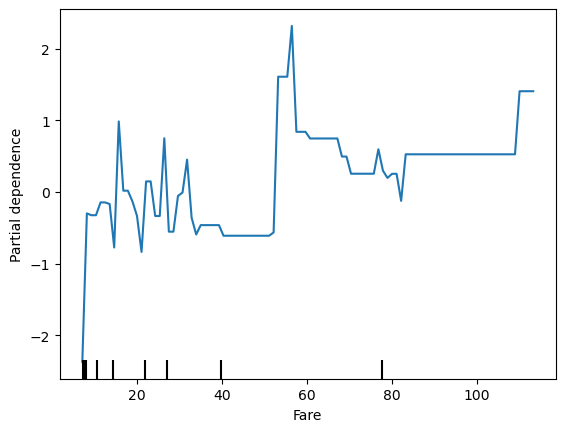

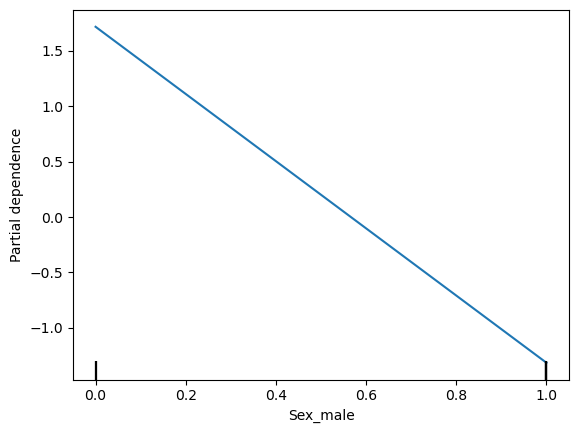

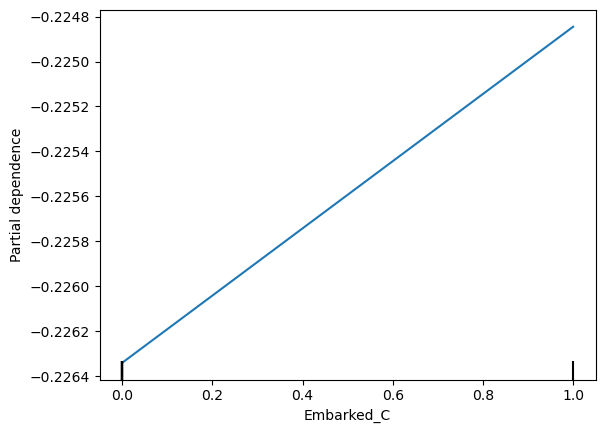

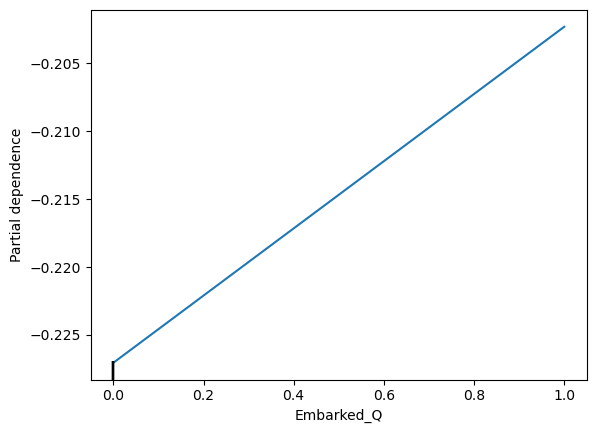

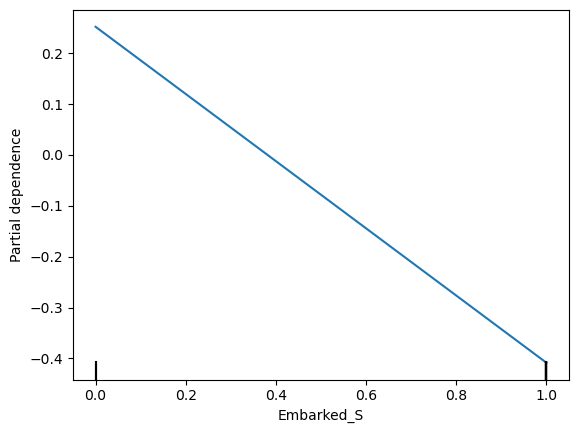

In [16]:
# Codigo for para partial dependence plot 
from sklearn.inspection import PartialDependenceDisplay

for i in range(len(X_train.keys())):
     PartialDependenceDisplay.from_estimator(
        best_model,
        X_train,
        [i],
        feature_names=X_train.columns
    )